In [1]:
import numpy as np
import pandas as pd
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will

In [11]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors

In [12]:
from sklearn.cluster import KMeans

In [13]:
tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

In [14]:
names = list(tables[0].iloc[0,:])
df = tables[0]
df.columns = df.iloc[0,:]
df = df[1:]

In [15]:
df = df[df['Borough'] != 'Not assigned']
df.head(10)

,Postcode,Borough,Neighbourhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront
6,M5A,Downtown Toronto,Regent Park
7,M6A,North York,Lawrence Heights
8,M6A,North York,Lawrence Manor
9,M7A,Queen's Park,Not assigned
11,M9A,Etobicoke,Islington Avenue
12,M1B,Scarborough,Rouge
13,M1B,Scarborough,Malvern


In [16]:
previous = ''
previous3 = ''
new_neighbourhoods = ''
bunched_neighbourhoods = ''
new_row = pd.DataFrame()
new_df = pd.DataFrame()
for row in df.values:
    neighbourhood = []
    current = row[0]
    current2 = row[1]
    current3 = row[2]
    if (previous3 in new_neighbourhoods) and (previous == current):
        new_neighbourhoods = '{}, {}'.format(new_neighbourhoods,current3)
        new_row = pd.DataFrame(np.array([[current, current2, new_neighbourhoods]]))
        new_df = pd.concat([new_df, new_row], axis=0)
        previous = current
        previous3 = current3
        
    elif (previous == current) and (previous3 not in new_neighbourhoods):
        new_neighbourhoods = '{}, {}'.format(previous3,current3)
        new_row = pd.DataFrame(np.array([[current, current2, new_neighbourhoods]]))
        new_df = pd.concat([new_df, new_row], axis=0)
        previous = current
        previous3 = current3
        
    else:
        new_row = pd.DataFrame(np.array([[current, current2, current3]]))
        new_df = pd.concat([new_df, new_row], axis=0)
        previous = current
        previous3 = current3
        
        
new_df.drop_duplicates(0, keep='last', inplace = True)
new_df.columns = ['Postcode','Borough','Neighbourhood']
new_df = new_df.reset_index().drop('index', axis=1)

In [17]:
lat_long_df = pd.read_csv('http://cocl.us/Geospatial_data')

In [18]:
lat_long_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [19]:
new_df = pd.merge(new_df, lat_long_df, left_on='Postcode', right_on='Postal Code')
new_df.head()

,Postcode,Borough,Neighbourhood,Postal Code,Latitude,Longitude
0,M3A,North York,Parkwoods,M3A,43.753259,-79.329656
1,M4A,North York,Victoria Village,M4A,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",M5A,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",M6A,43.718518,-79.464763
4,M7A,Queen's Park,Not assigned,M7A,43.662301,-79.389494


In [1]:
# @hidden_cell


CLIENT_ID = 'NTP5UIW04LWMVQV2VOKR55B2MNYDETIA5OYGTM2AJIBM00C3' # your Foursquare ID
CLIENT_SECRET = '4YD3IFJZYJE4ESM35JQWURKOZAHFYKVGUTWMREU5NXJR0IHV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NTP5UIW04LWMVQV2VOKR55B2MNYDETIA5OYGTM2AJIBM00C3
CLIENT_SECRET:4YD3IFJZYJE4ESM35JQWURKOZAHFYKVGUTWMREU5NXJR0IHV


In [21]:
#GO FROM SECTION 2!!

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 #max number of venues to get
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
torronto_venues = getNearbyVenues(new_df['Neighbourhood'], new_df['Latitude'], new_df['Longitude'], radius=500)

Parkwoods
Victoria Village
Harbourfront, Regent Park
Lawrence Heights, Lawrence Manor
Not assigned
Islington Avenue
Rouge, Malvern
Don Mills North
Woodbine Gardens, Parkview Hill
Ryerson, Garden District
Glencairn
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Highland Creek, Rouge Hill, Port Union
Flemingdon Park, Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Downsview North, Wilson Heights
Thorncliffe Park
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
East Birchmount Park, Ionview, Kennedy Park
Bayview Village
CFB Toronto, Downsview East
The D

In [24]:
torronto_venues['Neighborhood'][0:5]

0           Parkwoods
1           Parkwoods
2           Parkwoods
3           Parkwoods
4    Victoria Village
Name: Neighborhood, dtype: object

In [25]:
torronto_onehot = pd.get_dummies(torronto_venues[['Venue Category']],prefix='', prefix_sep='')
torronto_onehot['Neighborhood'] = torronto_venues['Neighborhood']
fixed_columns = [torronto_onehot.columns[-1]] + list(torronto_onehot.columns[:-1])
torronto_onehot = torronto_onehot[fixed_columns]

In [26]:
torronto_grouped = torronto_onehot.groupby('Neighborhood').mean().reset_index()

In [27]:
#Need to try multiple clustering algorithms for main project and use testing metrics
# set number of clusters
kclusters = 6

torronto_grouped_clustering = torronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(torronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
pd.Series(kmeans.labels_).unique()

array([1, 2, 4, 3, 5, 0])

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = torronto_grouped['Neighborhood']

for ind in np.arange(torronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(torronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Thai Restaurant,Steakhouse,American Restaurant,Bar,Burger Joint,Hotel,Bakery,Salad Place
1,Agincourt,Lounge,Breakfast Spot,Sandwich Place,Skating Rink,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Coffee Shop,Playground,Dog Run,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Beer Store,Fried Chicken Joint,Fast Food Restaurant,Pharmacy,Pizza Place,Sandwich Place,Coffee Shop,Airport Lounge,Falafel Restaurant
4,"Alderwood, Long Branch",Pizza Place,Gym,Coffee Shop,Athletics & Sports,Skating Rink,Pharmacy,Pub,Sandwich Place,Pool,Women's Store


In [30]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

torronto_merged = new_df.iloc[:,1:]
torronto_merged.rename(columns={'Neighbourhood':'Neighborhood'},inplace=True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
torronto_merged = torronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

torronto_merged.head() # check the last columns!

,Borough,Neighborhood,Postal Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,M3A,43.753259,-79.329656,2.0,Park,Fast Food Restaurant,Food & Drink Shop,Pool,Women's Store,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
1,North York,Victoria Village,M4A,43.725882,-79.315572,1.0,Hockey Arena,Coffee Shop,Pizza Place,Portuguese Restaurant,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
2,Downtown Toronto,"Harbourfront, Regent Park",M5A,43.654260,-79.360636,1.0,Coffee Shop,Park,Café,Pub,Bakery,Mexican Restaurant,Breakfast Spot,Theater,Event Space,Electronics Store
3,North York,"Lawrence Heights, Lawrence Manor",M6A,43.718518,-79.464763,1.0,Furniture / Home Store,Clothing Store,Women's Store,Gift Shop,Boutique,Miscellaneous Shop,Arts & Crafts Store,Event Space,Accessories Store,Vietnamese Restaurant
4,Queen's Park,Not assigned,M7A,43.662301,-79.389494,1.0,Coffee Shop,Gym,Diner,Japanese Restaurant,Fast Food Restaurant,Mexican Restaurant,Liquor Store,Portuguese Restaurant,Café,Bar


In [31]:
latitude = 43.6532
longitude = -79.3832
print('The geograpical coordinate of Torronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Torronto are 43.6532, -79.3832.


In [32]:
torronto_merged['Cluster Labels'] = torronto_merged['Cluster Labels'].fillna(1)

In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(torronto_merged['Latitude'], torronto_merged['Longitude'], torronto_merged['Neighborhood'], torronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Screen Shot of Clustering From the Above Output:
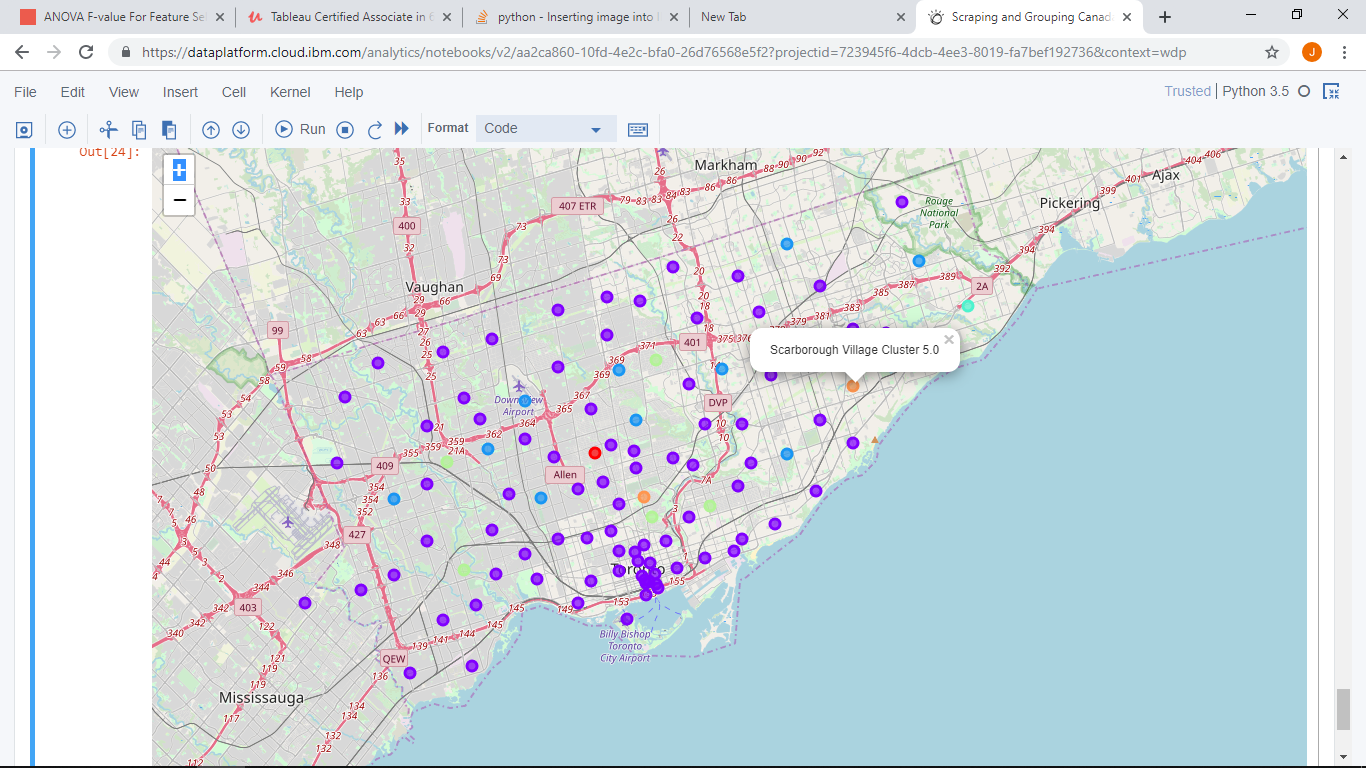